# HOME ASSIGNMENT #5: BIGQUERY SQL & PYTHON PANDAS

**Mục đích của bài Assignment**
> *  Upload Data từ Google Spreadsheet lên BigQuery và thao tác data với SQL
*  Thao tác với data bằng Pandas
*   `[Optional]` Data Visualization on Python

**Các kiến thức áp dụng**
* Slack API, JSON to DataFrame
* Google Spreadsheet to BigQuery
* SQL
* Python Pandas

**Lời Khuyên**
* Đây là bài tập nhẹ nhàng hơn các tuần trước
* Các bạn dành thời gian ôn lại và xâu chuỗi kiến thức

# TODO 1: BIGQUERY & SQL
* Làm theo Lab của Week 5: [HERE](https://anhdang.gitbook.io/datacracy/atom/5-sql-and-database-design/5.2-lab-upload-data-tu-google-sheet-to-bigquery)

In [ ]:
!pip install hyperlink

     |████████████████████████████████| 81kB 4.8MB/s 


In [ ]:
# Import Library
import requests # de goi api
import re # xu li data dang string
from datetime import datetime as dt #xu li dang datetime
import gspread # update data len google speadsheet
from gspread_dataframe import set_with_dataframe # update data len google speadsheet
import pandas as pd
import json
from oauth2client.service_account import ServiceAccountCredentials # nhap Google spreadsheet credentials
import os
import hyperlink # import hyperlink to print link
from hyperlink import URL
import numpy as np

In [ ]:
# (1) Code để pull Slack Data

In [ ]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/W5
with open('env_variable.json','r') as j:
  json_data = json.load(j)

/content/drive/MyDrive/W5


In [ ]:
## Load SLACK_BEARER_TOKEN
os.environ['SLACK_BEARER_TOKEN'] = json_data['SLACK_BEARER_TOKEN'] 

In [ ]:
# 1. USER LIST DATA

# Goi API tu endpoint
endpoint = "https://slack.com/api/users.list"
headers = {"Authorization": "Bearer {}".format(os.environ['SLACK_BEARER_TOKEN'])}
response_json = requests.post(endpoint, headers=headers).json() 
user_dat = response_json['members']

# Tao user dictionary
user_dict = {'user_id':[], 'name':[],'display_name':[],'real_name':[],'title':[],'phone':[],'is_bot':[]}
for i in range(len(user_dat)):
  user_dict['user_id'].append(user_dat[i]['id'])
  user_dict['name'].append(user_dat[i]['name'])
  user_dict['display_name'].append(user_dat[i]['profile']['display_name'])
  user_dict['real_name'].append(user_dat[i]['profile']['real_name_normalized'])
  user_dict['title'].append(user_dat[i]['profile']['title'])
  user_dict['phone'].append(user_dat[i]['profile']['phone'])
  user_dict['is_bot'].append(user_dat[i]['is_bot'])

# Convert dictionary thanh bang
user_df = pd.DataFrame(user_dict)
user_df = user_df.replace('', np.nan)
user_df.head(len(user_df))

,user_id,name,display_name,real_name,title,phone,is_bot
0,USLACKBOT,slackbot,Slackbot,Slackbot,NaN,NaN,False
1,U01AT4T75JB,loclexuan26392,Loc Le Xuan,Loc Le Xuan,NaN,NaN,False
2,U01AVDY7JET,locle.ds,Loc Le Xuan,Loc Le Xuan,NaN,NaN,False
3,U01BE2PR6LU,maianhdang.ftu,MAD,Dặng Huỳnh Mai Anh,Technical Contents,NaN,False
4,U01C48T7S1J,huyenhoang.design,Thanh Huyen Hoang,Thanh Huyen Hoang,NaN,NaN,False
...,...,...,...,...,...,...,...
72,U0233KHLM2M,vuthanhdat.contact,NaN,Vuthanhdat Contact,NaN,NaN,False
73,U023E0BAHQ8,testgettoken,NaN,test.gettoken,NaN,NaN,True
74,U023G7HDUL8,ass4,NaN,Ass4,NaN,NaN,True
75,U024A4CRKQC,contact.datacracy,DATAcracy,DATAcracy,NaN,NaN,False


In [ ]:
# 2. LIST OF SLACK CHANNELS

# Goi API endpoint
endpoint2 = "https://slack.com/api/conversations.list"
data = {'types': 'public_channel,private_channel'}
response_json2 = requests.post(endpoint2, headers=headers, data=data).json() 
channel_dat = response_json2['channels']

# Tao user dictionary
channel_dict = {'channel_id':[], 'channel_name':[], 'is_channel':[],'creator':[],'created_at':[],'topics':[],'purpose':[],'num_members':[]}
for i in range(len(channel_dat)):
  channel_dict['channel_id'].append(channel_dat[i]['id'])
  channel_dict['channel_name'].append(channel_dat[i]['name'])
  channel_dict['is_channel'].append(channel_dat[i]['is_channel'])
  channel_dict['creator'].append(channel_dat[i]['creator'])
  channel_dict['created_at'].append(dt.fromtimestamp(float(channel_dat[i]['created'])))
  channel_dict['topics'].append(channel_dat[i]['topic']['value'])
  channel_dict['purpose'].append(channel_dat[i]['purpose']['value'])
  channel_dict['num_members'].append(channel_dat[i]['num_members'])

# Convert dictionary thanh bang
channel_df = pd.DataFrame(channel_dict) 
channel_df = channel_df.replace('', np.nan) # -> replace khoảng trắng bằng giá trị NULL (nan)
channel_df.head()

,channel_id,channel_name,is_channel,creator,created_at,topics,purpose,num_members
0,C01B4PVGLVB,general,True,U01BE2PR6LU,2020-09-23 10:25:03,NaN,This is the one channel that will always inclu...,66
1,C01BYH7JHB5,contents,True,U01BE2PR6LU,2020-10-05 07:28:09,NaN,NaN,13
2,C01CAMNCJJV,branding-design,True,U01AVDY7JET,2020-10-05 03:16:30,NaN,NaN,9
3,C01U6P7LZ8F,atom-assignment1,True,U01BE2PR6LU,2021-04-17 07:00:04,Assigment#1 - Python Basics &amp; Spreadsheet ...,Where learners submit assignments and give rev...,44
4,C01UL6K1C7L,atom-week1,True,U01BE2PR6LU,2021-04-16 17:44:32,TOPIC: Data Strategy. Metrics Design. Spreadsh...,TOPIC: Data Strategy. Metrics Design. Spreadsh...,43


In [ ]:
# 3. MESSAGE INFORMATIOn

# Goi API
endpoint3 = "https://slack.com/api/conversations.history"

# Tao message dictionary
msg_dict = {'channel_id':[],'msg_id':[], 'msg_ts':[], 'user_id':[], 'latest_reply':[],'reply_user_count':[],'reply_users':[],'github_link':[]}
for channel_id, channel_name in zip(channel_df['channel_id'], channel_df['channel_name']):
  print('Channel ID: {} - Channel Name: {}'.format(channel_id, channel_name))
  try:
    data = {"channel": channel_id} 
    response_json = requests.post(endpoint3, data=data, headers=headers).json()
    msg_ls = response_json['messages']
    for i in range(len(msg_ls)):
      if 'client_msg_id' in msg_ls[i].keys():
        msg_dict['channel_id'].append(channel_id)
        msg_dict['msg_id'].append(msg_ls[i]['client_msg_id'])
        msg_dict['msg_ts'].append(dt.fromtimestamp(float(msg_ls[i]['ts'])))
        msg_dict['latest_reply'].append(dt.fromtimestamp(float(msg_ls[i]['latest_reply'] if 'latest_reply' in msg_ls[i].keys() else 0))) ## -> No reply: 1970-01-01
        msg_dict['user_id'].append(msg_ls[i]['user'])
        msg_dict['reply_user_count'].append(msg_ls[i]['reply_users_count'] if 'reply_users_count' in msg_ls[i].keys() else 0)
        msg_dict['reply_users'].append(msg_ls[i]['reply_users'] if 'reply_users' in msg_ls[i].keys() else 0) 
        ## -> Censor message contains tokens
        text = msg_ls[i]['text']
        github_link = re.findall('(?:https?://)?(?:www[.])?github[.]com/[\w-]+/?', text)
        msg_dict['github_link'].append(github_link[0] if len(github_link) > 0 else np.nan)
  except:
    print('====> '+ str(response_json))

# convert dictionary qua bang
msg_df = pd.DataFrame(msg_dict)
msg_df = msg_df.replace('', np.nan) 
msg_df.head()


Channel ID: C01B4PVGLVB - Channel Name: general
====> {'ok': False, 'error': 'not_in_channel'}
Channel ID: C01BYH7JHB5 - Channel Name: contents
====> {'ok': False, 'error': 'not_in_channel'}
Channel ID: C01CAMNCJJV - Channel Name: branding-design
====> {'ok': False, 'error': 'not_in_channel'}
Channel ID: C01U6P7LZ8F - Channel Name: atom-assignment1
Channel ID: C01UL6K1C7L - Channel Name: atom-week1
Channel ID: C01ULCHGN75 - Channel Name: atom-general
====> {'ok': False, 'error': 'not_in_channel'}
Channel ID: C020VMT58JK - Channel Name: topics-data-analytics
====> {'ok': False, 'error': 'not_in_channel'}
Channel ID: C0213MNH9L6 - Channel Name: topics-python
====> {'ok': False, 'error': 'not_in_channel'}
Channel ID: C0213N56M2A - Channel Name: topics-materials
====> {'ok': False, 'error': 'not_in_channel'}
Channel ID: C021FSDN7LJ - Channel Name: atom-assignment2
Channel ID: C021KLB0DSB - Channel Name: discuss-group3
Channel ID: C021KLB90GP - Channel Name: discuss-group4
Channel ID: C0220

,channel_id,msg_id,msg_ts,user_id,latest_reply,reply_user_count,reply_users,github_link
0,C01U6P7LZ8F,005AD620-BD06-4123-BC42-6118DAA73BA4,2021-05-13 14:09:48.011000,U01UTGRMGEQ,2021-05-13 18:01:34.021400,4,"[U01V00P4S2V, U01UTGRMGEQ, U01UMJ451V1, U01V00...",NaN
1,C01U6P7LZ8F,D86A48D2-D953-4504-92BF-D9240B2549A8,2021-05-10 04:51:46.004700,U01UJ9LG5U5,2021-05-15 09:14:31.003600,2,"[U01USGKQ771, U01V00KHHHP]",https://github.com/danhpcv/
2,C01U6P7LZ8F,246fb20c-8739-4664-9bcf-14f57aee17f7,2021-05-10 04:35:39.003800,U01UMC08KL2,2021-05-18 08:09:59.000800,2,"[U01UTGS5ZNY, U01UMC08KL2]",https://github.com/auslynnguyen/
3,C01U6P7LZ8F,4214088f-ccdc-4e8e-9c19-677ae3f439a1,2021-05-10 03:07:35.001200,U01UTGRQS9J,2021-05-15 09:28:16.004000,2,"[U01VB632FPS, U01V00KHHHP]",NaN
4,C01U6P7LZ8F,cfad12f7-bf9c-4209-b563-f495f378fb1f,2021-05-08 06:43:25.006900,U01BE2PR6LU,1970-01-01 00:00:00.000000,0,0,NaN


In [ ]:
# authorize bang json
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name(
    'analog-patrol-314318-59f5308f3dfa.json', scope)
gc = gspread.authorize(credentials)
print("DONE!")

DONE!


In [ ]:
# Code để upload data cua user list, channel, message lên Gsheet

## access google sheet
spreadsheet_key = '1VtmqGhJhod10Kd62x5Kl1uEpy5sk7xGWa6vdEW6R-8I'
sh = gc.open_by_key(spreadsheet_key)


## append data to sheet
set_with_dataframe(sh.get_worksheet(0), user_df)
set_with_dataframe(sh.get_worksheet(1), channel_df)
set_with_dataframe(sh.get_worksheet(2), msg_df)

## print
url = URL(scheme=u'https', host=u'docs.google.com',path=[u'spreadsheets',u'd',spreadsheet_key])
print("Data is update to workseet", url)

Data is update to workseet https://docs.google.com/spreadsheets/d/1VtmqGhJhod10Kd62x5Kl1uEpy5sk7xGWa6vdEW6R-8I


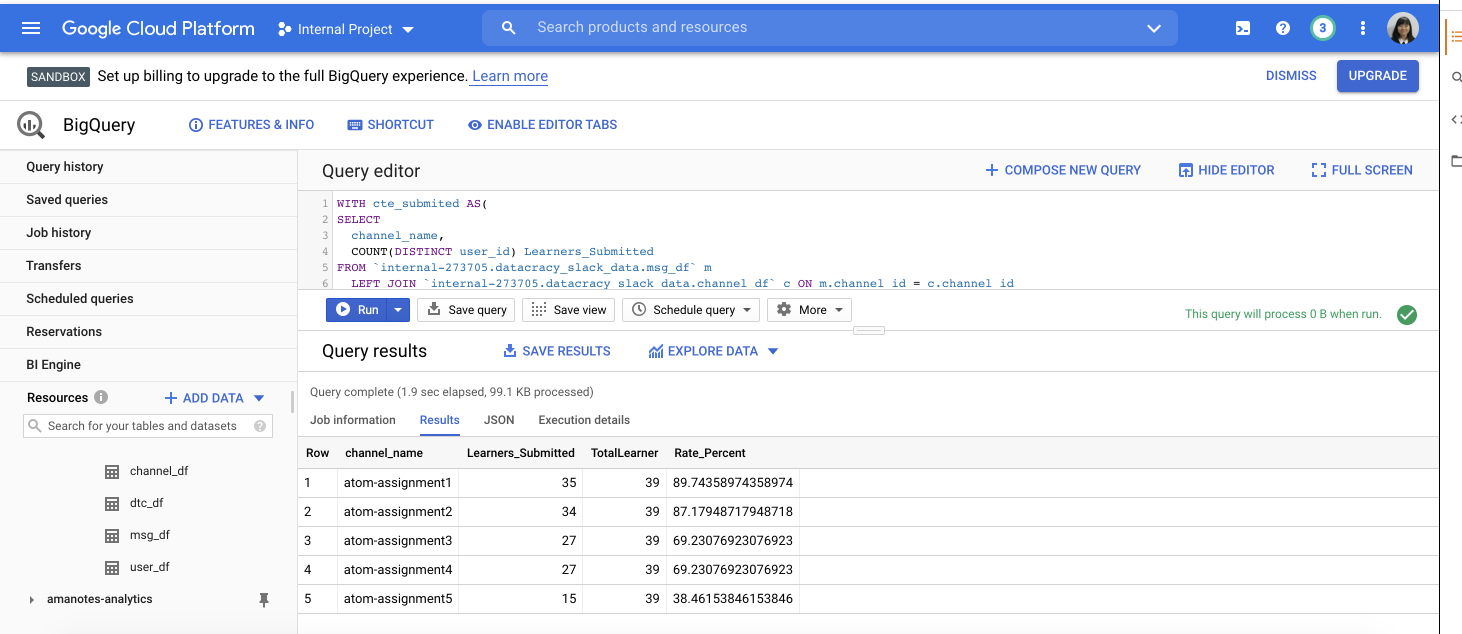

# TODO 2: Python Pandas
[Kaggle](https://www.kaggle.com/) là cộng đồng lớn nhất thế giới về Data Science với các cuộc thi/thử thách ML, các công cụ và tài liệu để học và phát triển kỹ năng
* Tạo account của bạn trên Kaggle
* Coi tutorial và làm 6 sets bài tập trên Kaggle [HERE](https://www.kaggle.com/learn/pandas)
* Bạn có thể làm bài trực tiếp trên Kaggle (cũng là dạng notebook online như Colab). Toàn bộ notebook sẽ lưu trên phần Code trong Profile Account của bạn
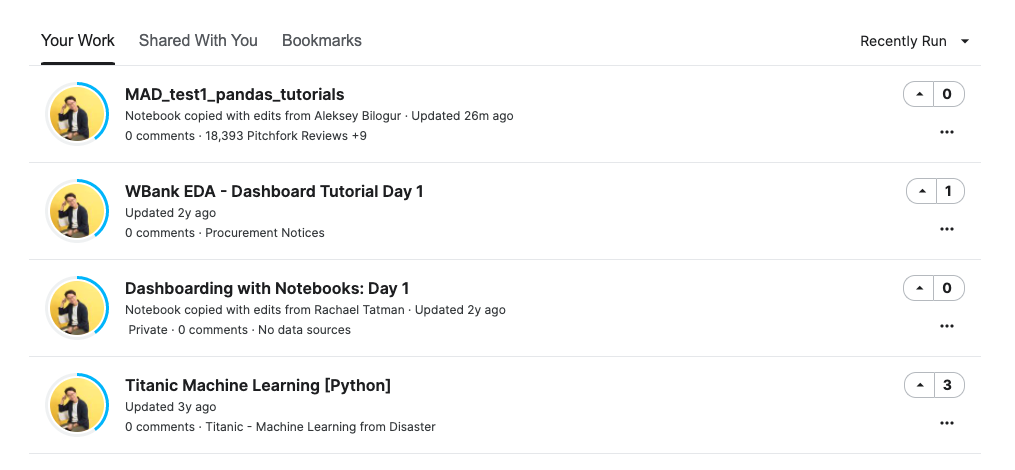

In [ ]:
# Copy các link Kaggle sau:
## 1. Link tới Kaggle Account của bạn -----> https://www.kaggle.com/nhduong2803
## 2. Link tới các bài tập
## Pandas 1: ---> https://www.kaggle.com/nhduong2803/exercise-creating-reading-and-writing/edit
## Pandas 2: ---> https://www.kaggle.com/nhduong2803/exercise-indexing-selecting-assigning/edit
## Pandas 3: ---> https://www.kaggle.com/nhduong2803/exercise-summary-functions-and-maps/edit
## Pandas 4: ---> https://www.kaggle.com/nhduong2803/exercise-grouping-and-sorting/edit
## Pandas 5: ---> https://www.kaggle.com/nhduong2803/exercise-data-types-and-missing-values/edit
## Pandas 6: ---> https://www.kaggle.com/nhduong2803/exercise-renaming-and-combining/edit

# TODO 3: Python Pandas 
Trở lại TODO7 [Assignment#4](https://github.com/anhdanggit/atom-assignments/blob/main/assignment_4/home_assignment_4.ipynb) (nếu bạn chưa hoàn thành)

In [ ]:
DONE

# TODO 4 (OPTIONAL): Python Data Viz
Coi tutorial và làm nhiều nhất có thể các sets bài tập trên [Kaggle Data Visualization](https://www.kaggle.com/learn/data-visualization)

In [ ]:
# Copy Link tới các bài tập
## DataViz 1: --->
## DataViz 2: --->
## DataViz 3: --->
## DataViz 4: --->
## DataViz 5: --->
## DataViz 6: --->
## DataViz 7: --->